В этой тетрадке мы разберём те вещи, которые раньше мы заметали под ковёр.

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Разминка: `.backward()`

Не запуская эту ячейку, можете ли вы сказать, что она напечатает?

In [9]:
x = torch.tensor(-3., requires_grad=True)
y = x**2
y.backward(torch.tensor(10))

print('x =', x)
print('y =', y)
print('x.grad =', x.grad)

x = tensor(-3., requires_grad=True)
y = tensor(9., grad_fn=<PowBackward0>)
x.grad = tensor(-60.)


А что насчёт этой ячейки? Как будет выглядеть график?

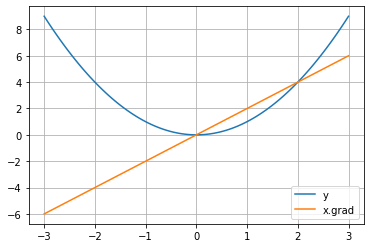

In [10]:
x = torch.linspace(-3, 3, 100, requires_grad=True)
y = x**2
# y.sum().backward()
y.backward(torch.ones(100))

plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), x.grad, label='x.grad')
plt.legend()
plt.grid()

Посчитайте градиент функции

$$
f(w) = \prod_{i,j} \log(\log(w_{ij} + 7))
$$

в точке `w = [[5,10], [1,2]]`.

In [11]:
# t.prod()
# torch.prod(t)

w = torch.tensor([[5,10], [1,2]], dtype=torch.float32, requires_grad=True)
f = torch.log(torch.log(w + 7)).prod()
f.backward()
w.grad

tensor([[0.0201, 0.0109],
        [0.0449, 0.0351]])

# 2. Пишем слои руками

Все слои торча, которые мы с вами уже использовали, являются наследниками класса `nn.Module`. Нас в нём будут больше всего интересовать методы `__init__` и `forward`.

In [12]:
def assert_identical_forward(torch_layer, my_layer, std=1):
    for _ in range(10):
        a = torch.randn(10, 3) * std
        assert torch.allclose(torch_layer(a), my_layer(a))

## 2.1. `nn.ReLU`

В качестве примера посмотрим, как можно реализовать `ReLU`.

In [13]:
class ReLU(nn.Module):  # наследуемся от nn.Module
    def forward(self, x):
        # На вход пришёл какой-то тензор x
        return torch.maximum(x, torch.tensor(0))  # Возвращаем max(x, 0)

assert_identical_forward(nn.ReLU(), ReLU())

In [14]:
assert_identical_forward(nn.ReLU(), ReLU())

In [15]:
layer = ReLU()
a = torch.randn(2, 3)
print(a)
print(layer.forward(a))

tensor([[-1.4139,  0.4703,  0.9649],
        [-0.3434,  2.8541,  0.8819]])
tensor([[0.0000, 0.4703, 0.9649],
        [0.0000, 2.8541, 0.8819]])


In [16]:
a[0, 0].item()

-1.413925290107727

In [17]:
torch.tensor([123]).item()

123

Разумеется, этим слоем можно пользоваться так же, как мы раньше пользовались стандартными слоями:

In [18]:
layer = ReLU()

x = torch.randn(2, 3)
print(x)

y = layer(x)
print(y)

tensor([[ 1.2389, -0.0456,  1.0801],
        [ 0.8366,  1.9840, -0.3059]])
tensor([[1.2389, 0.0000, 1.0801],
        [0.8366, 1.9840, 0.0000]])


## 2.2. Про шейпы

Дальше хотелось бы реализовать `nn.Softmax`, но там понадобится делить каждую строку тензора на знаменатель, единый для всей строки. Поймём, как это правильно сделать. Пусть у нас есть вот такой тензор:

In [19]:
a = torch.arange(15).reshape(5, 3)
print(a)
print(a.shape)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]])
torch.Size([5, 3])


Если просто сделать `a / a.sum(dim=1)`, то ничего не выйдет. Шейп `a` равен `(5, 3)`, `a.sum(dim=1)` — `(5,)`, и PyTorch не понимает, что мы от него хотим:

In [20]:
print(a.sum(dim=1))
print(a.sum(dim=1).shape)
print(a / a.sum(dim=1))

tensor([ 3, 12, 21, 30, 39])
torch.Size([5])


RuntimeError: ignored

А вот если изменить шейп `a.sum(dim=1)` на `(5, 1)`, то сработает броадкастинг: PyTorch увидит, что мы пытаемся разделить тензор с шейпом `(5, 3)` на тензор с шейпом `(5, 1)`, и корректно размножит второй тензор вдоль столбцов:

In [21]:
print(a.sum(dim=1, keepdim=True))
print(a.sum(dim=1, keepdim=True).shape)
print(a / a.sum(dim=1, keepdim=True))

tensor([[ 3],
        [12],
        [21],
        [30],
        [39]])
torch.Size([5, 1])
tensor([[0.0000, 0.3333, 0.6667],
        [0.2500, 0.3333, 0.4167],
        [0.2857, 0.3333, 0.3810],
        [0.3000, 0.3333, 0.3667],
        [0.3077, 0.3333, 0.3590]])


Давайте теперь попробуем написать вот такой слой:

$$
\left[ \operatorname{DivideBySum}(x) \right]_{ij} = \frac {x_{ij}} {\sum_{k = 1}^n x_{ik}}
$$

In [22]:
class DivideBySum(nn.Module):
    def forward(self, x):
        return x / x.sum(dim=1, keepdim=True)

assert_identical_forward(lambda x: x / x.sum(dim=1, keepdim=True), DivideBySum())

## 2.3. `nn.Softmax`

Можно написать `Softmax` прямо по определению:

$$
\left[ \operatorname{SoftmaxUnstable}(x) \right]_{ij} = \frac {\exp (x_{ij})} {\sum_{k = 1}^n \exp (x_{ik})}
$$

Давайте попробуем это сделать и убедимся, что второй тест (передающий на вход слою числа порядка 1000) не проходится:

In [23]:
class SoftmaxUnstable(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        exp = torch.exp(x)
        return exp / exp.sum(dim=1, keepdim=True)

assert_identical_forward(nn.Softmax(dim=1), SoftmaxUnstable())
assert_identical_forward(nn.Softmax(dim=1), SoftmaxUnstable(), std=1000)

AssertionError: ignored

In [ ]:
layer = SoftmaxUnstable()
layer(torch.randn(2, 3) * 1000)

Вместо этого лучше писать Softmax, поделив числитель и знаменатель на наибольшую экспоненту:

$$
\left[ \operatorname{Softmax}(x) \right]_{ij} = \frac {\exp (x_{ij} - x_{i \text{, max}})} {\sum_{k = 1}^n \exp (x_{ik} - x_{i \text{, max}})}, \quad \text{ где } x_{i \text{, max}} = \max_j x_{ij}
$$

In [24]:
class Softmax(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        x = x - x.max(dim=1, keepdim=True)[0]
        exp = torch.exp(x)
        return exp / exp.sum(dim=1, keepdim=True)

assert_identical_forward(nn.Softmax(dim=1), Softmax())
assert_identical_forward(nn.Softmax(dim=1), Softmax(), std=1000)

In [25]:
layer = Softmax()
layer(torch.randn(2, 3) * 1000)

tensor([[0., 1., 0.],
        [1., 0., 0.]])

## 2.4. `nn.LogSoftmax`

Аналогично `Softmax`, можно написать по определению и убедиться, что это не работает:

$$
\left[ \operatorname{LogSoftmaxUnstable}(x) \right]_{ij} =
\log \left[ \operatorname{Softmax}(x) \right]_{ij}
$$

Естественно, это не работает, если подставить `SoftmaxUnstable`:

In [26]:
class LogSoftmaxVeryUnstable(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        return torch.log(SoftmaxUnstable()(x))

LogSoftmaxVeryUnstable()(torch.randn(10, 3) * 1000)

tensor([[-inf, -inf, nan],
        [-inf, nan, nan],
        [-inf, nan, -inf],
        [nan, -inf, -inf],
        [-inf, -inf, nan],
        [-inf, -inf, nan],
        [-inf, nan, -inf],
        [nan, nan, nan],
        [-inf, nan, -inf],
        [-inf, nan, nan]])

Но даже и с обычным `Softmax` тоже ничего не выходит:

In [27]:
class LogSoftmaxUnstable(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        return torch.log(Softmax()(x))

LogSoftmaxUnstable()(torch.randn(10, 3) * 1000)

tensor([[-inf, -inf, 0.],
        [0., -inf, -inf],
        [0., -inf, -inf],
        [-inf, -inf, 0.],
        [-inf, 0., -inf],
        [-inf, 0., -inf],
        [0., -inf, -inf],
        [0., -inf, -inf],
        [-inf, -inf, 0.],
        [0., -inf, -inf]])

Вместо этого лучше сделать преобразование, аналогичное тому, которое мы сделали с `Softmax`:

$$
\begin{multline*}
\left[ \operatorname{LogSoftmaxUnidiomatic}(x) \right]_{ij} =
\log \left[ \operatorname{Softmax}(x) \right]_{ij} = \\
\log \left( \frac {\exp(x_{ij})} {\sum_{k=1}^n \exp(x_{ik})} \right) =
x_{ij} - \log\left( \sum_{k=1}^n \exp(x_{ik}) \right) =
x_{ij} - \log\left( \exp(x_{i \text{, max}}) \sum_{k=1}^n \exp(x_{ij} - x_{i \text{, max}}) \right) = \\
x_{ij} - \left[ x_{i \text{, max}} + \log\left( \sum_{k=1}^n \exp(x_{ij} - x_{i \text{, max}}) \right) \right] =
\left[ x_{ij} - x_{i \text{, max}} \right] - \log\left( \sum_{k=1}^n \exp(x_{ij} - x_{i \text{, max}}) \right) ,
\end{multline*}
$$

где $x_{i \text{, max}} = \max \left\{ x_i \right\}$.

In [28]:
class LogSoftmaxUnidiomatic(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        x = x - x.max(dim=1, keepdim=True)[0]
        exp = torch.exp(x)
        return x - torch.log(exp.sum(dim=1, keepdim=True))

assert_identical_forward(nn.LogSoftmax(dim=1), LogSoftmaxUnidiomatic())
assert_identical_forward(nn.LogSoftmax(dim=1), LogSoftmaxUnidiomatic(), std=1000)

Наконец, для логарифма знаменателя `Softmax` в PyTorch есть специальная функция `torch.logsumexp`. Воспользуемся ей:

$$
\left[ \operatorname{LogSoftmax}(x) \right]_{ij} =
\left[ x_{ij} - x_{i \text{, max}} \right] - \left[ \operatorname{logsumexp} (x_i - x_{i \text{, max}}) \right]_{ij}
$$

In [29]:
class LogSoftmax(nn.Module):
    def forward(self, x):
        assert len(x.shape) == 2
        x = x - x.max(dim=1, keepdim=True)[0]
        return x - torch.logsumexp(x, dim=1, keepdim=True)

assert_identical_forward(nn.LogSoftmax(dim=1), LogSoftmax())
assert_identical_forward(nn.LogSoftmax(dim=1), LogSoftmax(), std=1000)

В принципе, можно было бы использовать и более простую формулу:

$$
\left[ \operatorname{LogSoftmax}(x) \right]_{ij} =
x_{ij} - \left[ \operatorname{logsumexp} (x) \right]_{ij}
$$

но из-за неточности вычислений с плавающей точкой мы не смогли бы свериться с PyTorch, который использует именно предыдущую формулу.

## 2.5. `nn.NLLLoss`

Вспомним, что, решая задачу классификации, мы всего лишь пытаемся максимизировать предсказываемый логарифм вероятности для истинного класса (или, что то же самое, минимизировать минус логарифм). На выходе нашего классификатора будет матрица, где по строкам будут разные сэмплы, а по столбцам логарифмы вероятностей для каждого из классов.

$$
\operatorname{NLLLoss}(p, c) = - \frac 1 n \sum_{i = 1}^n p_{i, c_i}
$$

Чтобы максимизировать вероятности истинных классов, надо их выбрать из такой матрицы. В PyTorch можно это сделать так:

In [30]:
p = DivideBySum()(torch.rand(5, 3))
c = torch.randint(3, (5,))
print('p:\n', p)
print('c:\n', c)
print('p indexed by c:\n', p[torch.arange(5), c])

p:
 tensor([[0.4197, 0.2304, 0.3499],
        [0.0105, 0.7395, 0.2499],
        [0.4182, 0.4543, 0.1275],
        [0.7211, 0.2476, 0.0313],
        [0.2421, 0.4965, 0.2614]])
c:
 tensor([1, 2, 2, 2, 0])
p indexed by c:
 tensor([0.2304, 0.2499, 0.1275, 0.0313, 0.2421])


А теперь реализуем собственно `NLLLoss`:

In [31]:
class NLLLoss(nn.Module):
    def forward(self, predicted_probs, true_classes):
        batch_size = predicted_probs.shape[0]
        return -predicted_probs[torch.arange(batch_size), true_classes].mean()

for _ in range(10):
    p = DivideBySum()(torch.rand(10, 3))
    c = torch.randint(3, (10,))
    assert torch.allclose(nn.NLLLoss()(p, c), NLLLoss()(p, c))

## 2.6. `nn.CrossEntropyLoss`

`CrossEntropyLoss` — это всего лишь `LogSoftmax`, за которым идёт `NLLLoss`. Но мы реализуем ещё несколько вариантов, чтобы убедиться, что они работают хуже.

In [32]:
class CrossEntropyLossVeryUnstable(nn.Module):
    def forward(self, predicted_logits, true_classes):
        # Используйте LogSoftmaxVeryUnstable
        return NLLLoss()(LogSoftmaxVeryUnstable()(predicted_logits), true_classes)

for _ in range(10):
    logits = torch.randn(10, 3)
    c = torch.randint(3, (10,))
    assert torch.allclose(nn.CrossEntropyLoss()(logits, c), CrossEntropyLossVeryUnstable()(logits, c))

In [33]:
class CrossEntropyLossUnstable(nn.Module):
    def forward(self, predicted_logits, true_classes):
        # Используйте LogSoftmaxUnstable
        return NLLLoss()(LogSoftmaxUnstable()(predicted_logits), true_classes)

for _ in range(10):
    logits = torch.randn(10, 3)
    c = torch.randint(3, (10,))
    assert torch.allclose(nn.CrossEntropyLoss()(logits, c), CrossEntropyLossUnstable()(logits, c))

In [34]:
class CrossEntropyLoss(nn.Module):
    def forward(self, predicted_logits, true_classes):
        # Используйте LogSoftmax
        return NLLLoss()(LogSoftmax()(predicted_logits), true_classes)

for _ in range(10):
    logits = torch.randn(10, 3)
    c = torch.randint(3, (10,))
    assert torch.allclose(nn.CrossEntropyLoss()(logits, c), CrossEntropyLoss()(logits, c))

## 2.7. `nn.Linear`

Наконец займёмся самой важной частью — линейным слоем:

$$
\operatorname{Linear}(x) = x \cdot W + b
$$

Для этого нам понадобится завести обучаемые параметры `W` и `b`. Будем хранить их прямо внутри класса.

Первое желание — это просто положить их в параметры класса как тензоры (`self.weight = torch.tensor(...)`). Так в принципе тоже можно делать, но хотелось бы иметь механизм, позволяющий помечать тензоры внутри класса как обучаемые и необучаемые. В PyTorch такой механизм предоставляет класс `nn.Parameter`.

In [35]:
class Linear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        weight = torch.randn(dim_in, dim_out)
        self.weight = nn.Parameter(weight)
        
        bias = torch.randn(dim_out)
        self.bias = nn.Parameter(bias)
        
    def forward(self, x):
        # Input: torch tensor with shape batch x dim_in
        # Output: torch tensor with shape batch x dim_out
        return x @ self.weight + self.bias

In [36]:
Linear(3, 5)(torch.randn(2, 3))

tensor([[-0.7838, -0.9186, -1.1036,  0.1900,  0.4201],
        [ 0.6954, -1.8461,  0.0044, -0.6060, -1.5336]], grad_fn=<AddBackward0>)

In [37]:
Linear(3, 5).weight.shape

torch.Size([3, 5])

In [38]:
nn.Linear(3, 5).weight.shape

torch.Size([5, 3])

## 2.8 Уже можно собрать модель!

In [39]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(10, 5)  # линейный слой с 10 входами и 5 выходами
        self.relu = ReLU()
        self.fc2 = Linear(5, 1)  # линейный слой с 5 входами и 1 выходом
        
    def forward(self, x):
        # Примените последовательно все три слоя и верните результат
        
        # Можно кратко:
        # return self.fc2(self.relu(self.fc1(x)))
        
        # Можно длинно:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

my_model = MyModel()
x = torch.randn(3, 10)
y = my_model(x)
print(y)
print(y.shape)

tensor([[-0.1895],
        [ 5.2005],
        [ 3.6246]], grad_fn=<AddBackward0>)
torch.Size([3, 1])


## 2.9. Но лучше всё-таки ещё сделать `nn.Sequential`

Чтобы сделать контейнер для нескольких слоёв, запускающихся последовательно, достаточно сложить все эти слои внутрь класса. Для этого в PyTorch есть `nn.ModuleList`:

In [40]:
class Sequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.submodules = nn.ModuleList(args)
        
    def forward(self, x):
        for submodule in self.submodules:
            x = submodule(x)
        return x

# 3. И ещё раз собираем модель

In [41]:
# Такая же модель, как выше, но через наш Sequential
my_model = Sequential(
    Linear(10, 5),
    ReLU(),
    Linear(5, 1)
)

x = torch.randn(3, 10)
y_pred = my_model(x)
print(y_pred)
print(y_pred.shape)

tensor([[-2.0841],
        [ 4.9305],
        [ 8.4954]], grad_fn=<AddBackward0>)
torch.Size([3, 1])


# 4. `torch.optim.SGD`

Оптимизатор получает на вход список из обучаемых параметров модели. У наследников класса `nn.Module` его можно получить через метод `.parameters()`. От оптимизатора мы хотим два метода: `.step()` и `.zero_grad()`.

In [42]:
class SGD:
    def __init__(self, parameters, lr):
        self.model_parameters = list(parameters)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.model_parameters:
                if p.grad is not None:
                    dL_dp = p.grad
                    p -= self.lr * dL_dp
    
    def zero_grad(self):
        for p in self.model_parameters:
            if p.grad is not None:
                p.grad.zero_()

# 5. Датасет

В этот раз поэкспериментируем на [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). По формату он точно такой же как MNIST (60k картинок в трейне, 10k для валидации, 10 классов, чёрно-белые картинки размером 28x28 пикселей), но на MNIST можно элементарно получить точность 97%, а на FashionMNIST сходу можно набрать только где-то 75%.

## 5.1. Скачиваем и смотрим на данные

In [43]:
from pathlib import Path
from torch.hub import _get_torch_home

# На Linux датасет скачается в ~/.cache/torch/datasets, но можете выбрать любую другую папку
datasets_path = Path(_get_torch_home()) / 'datasets'

dataset_train = torchvision.datasets.FashionMNIST(
    datasets_path, train=True, download=True,
    transform=torchvision.transforms.ToTensor()
) # используем готовый класс от торча для загрузки данных для тренировки
dataset_valid = torchvision.datasets.FashionMNIST(
    datasets_path, train=False, download=True,
    transform=torchvision.transforms.ToTensor()
) # используем готовый класс от торча для загрузки данных для валидации

class_idx_to_name = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}


Extracting /root/.cache/torch/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/torch/datasets/FashionMNIST/raw




Extracting /root/.cache/torch/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/torch/datasets/FashionMNIST/raw




Extracting /root/.cache/torch/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/torch/datasets/FashionMNIST/raw




Extracting /root/.cache/torch/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/torch/datasets/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


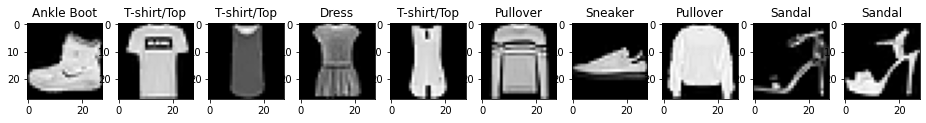

In [44]:
plt.figure(figsize=(16, 10))
n = 10
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(dataset_train[i][0].squeeze(0).numpy().reshape([28, 28]), cmap='gray')
    plt.title(class_idx_to_name[dataset_train[i][1]])
plt.show()

## 5.2. Делаем функцию для формирования батчей

Библиотека `torchvision` скачала данные за нас и дала нам такой интерфейс:

```
dataset[i] = (tensor(shape=(1, 28, 28)), int)
              \_______________________/  \_/
                          x               y
```

Порядок размерностей у картинок в PyTorch `CHW` (`channel`, `height`, `width`; в Tensorflow используется `HWC`). Здесь шейп у тензоров `(1, 28, 28)`, то есть у картинок 1 цветовой канал и размеры 28x28 пикселей.

Нам понадобится функция, которая принимает на вход список индексов элементов датасета и выдаёт батч из соответствующих элементов:

In [45]:
def make_batch_from_indices(dataset, indices):
    images = []
    targets = []
    for j in indices:
        image, target = dataset[j]
        images.append(image)
        targets.append(target)

    x_batch = torch.stack(images, dim=0)
    y_batch = torch.tensor(targets, dtype=torch.int64)
    
    return x_batch, y_batch

x_batch, y_batch = make_batch_from_indices(dataset_valid, [0, 3, 100, 500, 800, 5000, 9001])
print(x_batch.shape)
print(y_batch)

torch.Size([7, 1, 28, 28])
tensor([9, 1, 3, 2, 7, 2, 9])


# 6. Обучение

In [46]:
num_epochs = 10
batch_size = 200
learning_rate = 0.01

## 6.1. Создаём все нужные объекты

Воспользуемся всем, что мы уже написали, и создадим нейронку с $1 \cdot 28 \cdot 28$ числами на входе, $128$ промежуточными активациями и $10$ (по количеству классов) числами на выходе. В качестве функции активации возьмём `ReLU`.

In [47]:
def make_new_model():
    return Sequential(
        Linear(28**2, 128),
        ReLU(),
        Linear(128, 10),
    )

model = make_new_model()

Попробуем разные варианты для `criterion`: `CrossEntropyLossVeryUnstable`, `CrossEntropyLossUnstable` и, наконец, `CrossEntropyLoss`.

In [48]:
criterion = CrossEntropyLoss()

Наш оптимизатор!

In [49]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3362, -0.8164,  1.4391,  ...,  0.9127,  0.5343, -0.8218],
         [ 0.9692, -0.4857, -1.0964,  ...,  0.7505,  0.0149,  0.1606],
         [-0.1964,  0.8722,  1.2376,  ..., -0.8211,  0.4143, -0.0208],
         ...,
         [-0.4617,  1.4673,  1.0232,  ...,  2.0474,  1.5050,  1.7411],
         [-1.2503,  2.1629,  0.5605,  ...,  2.9075, -0.7998, -1.5632],
         [ 1.0494, -0.6583,  0.8839,  ..., -0.0473,  1.2138,  0.9211]],
        requires_grad=True), Parameter containing:
 tensor([ 0.4282, -1.3583, -1.2749,  0.5509, -1.8456,  1.4170, -1.3319, -2.9179,
         -0.7553,  0.8348,  1.9271,  0.5171, -0.1540, -1.0517,  0.6835, -0.4908,
          1.8669,  0.6380,  0.1024,  1.6768,  0.6918,  0.2149, -1.1148, -0.7653,
          2.0581, -0.3757,  0.8403,  0.9351, -0.4247,  0.2083,  0.2947,  0.0600,
          0.2187,  0.5671,  1.3144,  0.6750, -0.9259,  0.4418,  0.1464, -0.3455,
          1.7057,  0.3367, -0.4241, -1.7741, -0.6296,  0.1719, -0.7053,  0.1310,

In [50]:
opt = SGD(model.parameters(), lr=learning_rate)

## 6.2. Запускаем обучающий цикл

In [76]:
with tqdm(range(1, num_epochs + 1)) as progress_bar:
    for epoch in progress_bar:
        # Обучение

        # Создаём случайную перестановку индексов обучающего датасета
        indices_train = np.arange(len(dataset_train))
        np.random.shuffle(indices_train)

        for i in range(0, len(dataset_train), batch_size):
            # Формируем батч
            batch_indices = indices_train[i:i+batch_size]  # выбираем очередную порцию индексов...
            x_batch, y_batch = make_batch_from_indices(dataset_train, batch_indices)  # ... и строим по ней батч

            # flatten: (B, 1, 28, 28) -> (B, 28 * 28)
            x_batch = x_batch.reshape(batch_size, 28 * 28)

            y_pred = model(x_batch)  # делаем предсказания
            loss = criterion(y_pred, y_batch)  # считаем лосс

            assert np.isfinite(loss.item())  # проверяем, что всё посчиталось корректно

            # Считаем градиенты и делаем шаг оптимизатора, не забыв обнулить градиенты
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Валидация
            
        valid_losses = []  # сюда будем складывать средний лосс по батчам
        valid_accuracies = []
        # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
        with torch.no_grad():
            # Создаём список из индексов валидационного датасета (перемешивать их не обязательно)
            indices_valid = np.arange(len(dataset_valid))
            
            for i in range(0, len(dataset_valid), batch_size):
                # Формируем батч
                batch_indices = indices_valid[i:i + batch_size]
                x_batch, y_batch = make_batch_from_indices(dataset_valid, batch_indices)
                
                x_batch = x_batch.reshape(batch_size, -1) # flatten
                y_pred = model(x_batch) # делаем предсказания
                loss = criterion(y_pred, y_batch) # считаем лосс
                
                valid_losses.append(loss.numpy()) # добавляем в массив
                valid_accuracies.extend((torch.argmax(y_pred, dim=-1) == y_batch).numpy().tolist())

        # выводим статистику
        valid_loss = np.mean(valid_losses)
        valid_accuracy = np.mean(valid_accuracies)
        stats = f'loss: {valid_loss:.5f}, accuracy: {valid_accuracy:.4f}'
        print(f'Epoch: {epoch}, {stats}')
        progress_bar.set_postfix_str(stats)

Epoch: 1, loss: 9.44166, accuracy: 0.6564
Epoch: 2, loss: 6.84889, accuracy: 0.6957
Epoch: 3, loss: 5.55210, accuracy: 0.7140
Epoch: 4, loss: 4.70698, accuracy: 0.7214
Epoch: 5, loss: 4.16714, accuracy: 0.7284
Epoch: 6, loss: 3.62175, accuracy: 0.7391
Epoch: 7, loss: 3.27679, accuracy: 0.7420
Epoch: 8, loss: 2.90390, accuracy: 0.7435
Epoch: 9, loss: 2.65518, accuracy: 0.7391
Epoch: 10, loss: 2.40977, accuracy: 0.7477



## 6.3. Смотрим на результаты

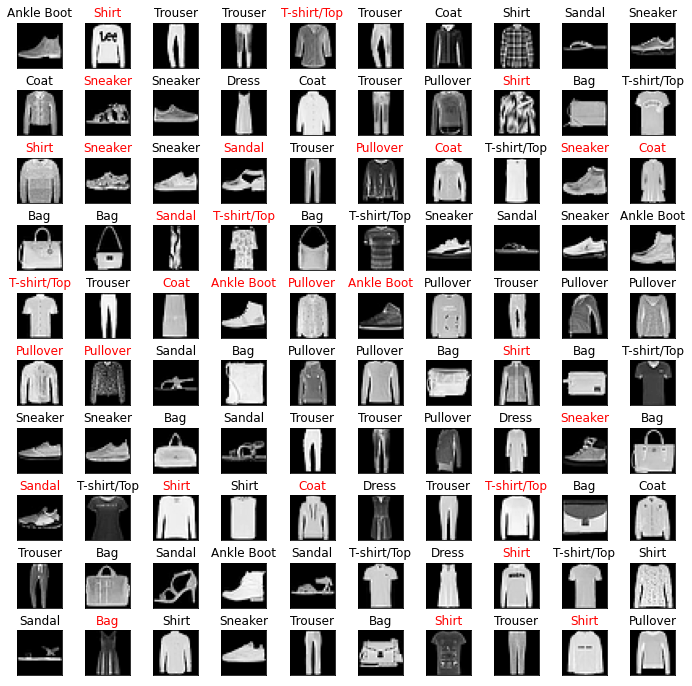

In [77]:
rows = 10
cols = 10

f, axarr = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        axarr[i, j].imshow(dataset_valid[idx][0].squeeze(0).numpy().reshape([28, 28]), cmap='gray')
        y_true = dataset_valid[idx][1]
        y_pred = torch.argmax(model(dataset_valid[idx][0].reshape(1, 784)).squeeze(0), dim=-1).item()
        axarr[i, j].set_title(class_idx_to_name[y_pred], color='black' if y_true == y_pred else 'red')

for ax in f.axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.5)
plt.show()

# 7. `torch.utils.data.DataLoader`

Поработав руками с индексами, можно видеть, почему `DataLoader` — удобная абстракция. Реализуем его руками.

## 7.1. Пишем свой `DataLoader`

Надо завернуть в класс следующие штуки:

1. Создание и перемешивание списка индексов;
2. Вызов функции `make_batch_from_indices()`;
3. Отслеживание текущего положения итератора.

In [51]:
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __iter__(self):
        return DataLoaderIter(self)

class DataLoaderIter:
    def __init__(self, dataloader):
        self.dataset = dataloader.dataset
        self.indices = np.arange(len(self.dataset))
        if dataloader.shuffle:
            np.random.shuffle(self.indices)
        self.batch_size = dataloader.batch_size
        self.position = 0
    
    def __next__(self):
        if self.position >= len(self.indices):
            raise StopIteration

        # Вызываем make_batch_from_indices() с правильными аргументами
        indices = self.indices[self.position:self.position+self.batch_size]
        x_batch, y_batch = make_batch_from_indices(self.dataset, indices)
        
        # Обновляем self.position
        self.position += self.batch_size

        return x_batch, y_batch

## 7.2. Переписываем обучающий цикл со своим `DataLoader`

In [52]:
train_dataloader = DataLoader(dataset_train, batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size)

In [53]:
model = make_new_model()

In [54]:
opt = SGD(model.parameters(), lr=learning_rate)

In [82]:
with tqdm(range(1, num_epochs + 1)) as progress_bar:
    for epoch in progress_bar:
        # Трейн
        for x_batch, y_batch in train_dataloader:
            # Батчи приезжают из даталоадера уже готовыми, их достаточно только решейпнуть

            # flatten: (B, 1, 28, 28) -> (B, 28 * 28)
            x_batch = x_batch.reshape(batch_size, -1)

            y_pred = model(x_batch)  # делаем предсказания
            loss = criterion(y_pred, y_batch)  # считаем лосс

            assert np.isfinite(loss.item())  # проверяем, что всё посчиталось корректно

            # Считаем градиенты и делаем шаг оптимизатора, не забыв обнулить градиенты
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        # Валидация
        valid_losses = []
        valid_accuracies = []
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                # Батчи приезжают из даталоадера уже готовыми, их достаточно только решейпнуть
                
                x_batch = x_batch.reshape(batch_size, -1) # flatten
                y_pred = model(x_batch) # делаем предсказания
                loss = criterion(y_pred, y_batch) # считаем лосс

                valid_losses.append(loss.numpy())
                valid_accuracies.extend((torch.argmax(y_pred, dim=-1) == y_batch).numpy().tolist())

        valid_loss = np.mean(valid_losses)
        valid_accuracy = np.mean(valid_accuracies)
        stats = f'loss: {valid_loss:.5f}, accuracy: {valid_accuracy:.4f}'
        print(f'Epoch: {epoch}, {stats}')
        progress_bar.set_postfix_str(stats)

Epoch: 1, loss: 9.70481, accuracy: 0.6457
Epoch: 2, loss: 7.24560, accuracy: 0.6814
Epoch: 3, loss: 5.82933, accuracy: 0.7146
Epoch: 4, loss: 4.96224, accuracy: 0.7285
Epoch: 5, loss: 4.33726, accuracy: 0.7384
Epoch: 6, loss: 3.87359, accuracy: 0.7445
Epoch: 7, loss: 3.53118, accuracy: 0.7476
Epoch: 8, loss: 3.24558, accuracy: 0.7533
Epoch: 9, loss: 2.93873, accuracy: 0.7575
Epoch: 10, loss: 2.69111, accuracy: 0.7593



В заключение обсудим технические вопросы. 

# 8. GPU

В PyTorch каждый тензор физически находится в памяти, принадлежащей какому-то устройству: RAM (которую контролирует CPU) или в GPU-памяти.

In [55]:
a = torch.zeros(1)
a.device

device(type='cpu')

В Colab по умолчанию выключена GPU, чтобы экономить ресурсы Гугла. Если вы смотрите этот ноутбук через Colab, то нажмите `Runtime` -> `Change runtime type` и в списке выберите `GPU`. Это перезагрузит ваш ноутбук, и вам придётся перезапустить какие-то из ячеек выше.

Когда у вас есть работающая GPU, тензор можно одной командой туда перенести:

In [56]:
device = 'cuda:0'

In [57]:
a = a.to(device)  # или .to('cuda') или .cuda()
a.device

device(type='cuda', index=0)

Обратно тоже можно:

In [58]:
a = a.to('cpu')  # или a.cpu()
a.device

device(type='cpu')

Аналогично можно делать и с целыми моделями, хранящими в себе много тензоров:

In [59]:
model = make_new_model()
model = model.to(device)

У модели нет поля `.device`, потому что разные тензоры, из которых состоит модель, могут лежать на разных устройствах (например, на разных видеокартах).

Создание оптимизатора не меняется:

In [60]:
opt = SGD(model.parameters(), lr=learning_rate)

В обучающем цикле понадобится:

1. После получения батчей из `DataLoader` перенести их на GPU;
2. После вычисления метрик перенести их обратно в оперативную память.

In [62]:
with tqdm(range(1, num_epochs + 1)) as progress_bar:
    for epoch in progress_bar:
        # Трейн
        for x_batch, y_batch in train_dataloader:
            # flatten: (B, 1, 28, 28) -> (B, 28 * 28)
            x_batch = x_batch.reshape(batch_size, -1)

            # Переносим батч на GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)  # делаем предсказания
            loss = criterion(y_pred, y_batch)  # считаем лосс

            assert np.isfinite(loss.item())  # .item() сделает .to('cpu') за нас

            # Считаем градиенты и делаем шаг оптимизатора, не забыв обнулить градиенты
            opt.zero_grad()
            loss.backward()
            opt.step()

        valid_losses = []
        valid_accuracies = []
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                x_batch = x_batch.reshape(batch_size, -1) # flatten

                # Переносим батч на GPU
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch) # делаем предсказания
                loss = criterion(y_pred, y_batch) # считаем лосс

                valid_losses.append(loss.item())  # .item() сделает .to('cpu') за нас
                # В следующей строке добавилось .to('cpu')
                valid_accuracies.extend((torch.argmax(y_pred, dim=-1) == y_batch).to('cpu').numpy().tolist())

        # выводим статистику
        valid_loss = np.mean(valid_losses)
        valid_accuracy = np.mean(valid_accuracies)
        stats = f'loss: {valid_loss:.5f}, accuracy: {valid_accuracy:.4f}'
        print(f'Epoch: {epoch}, {stats}')
        progress_bar.set_postfix_str(stats)

Epoch: 1, loss: 9.51413, accuracy: 0.6504
Epoch: 2, loss: 6.93340, accuracy: 0.6855
Epoch: 3, loss: 5.48304, accuracy: 0.7065
Epoch: 4, loss: 4.52900, accuracy: 0.7215
Epoch: 5, loss: 3.91635, accuracy: 0.7310
Epoch: 6, loss: 3.49295, accuracy: 0.7304
Epoch: 7, loss: 3.10098, accuracy: 0.7408
Epoch: 8, loss: 2.88422, accuracy: 0.7312
Epoch: 9, loss: 2.56621, accuracy: 0.7442
Epoch: 10, loss: 2.36869, accuracy: 0.7443



На такой маленькой модели, как эта, мы не увидим ускорение из-за использования GPU и, скорее всего, обучение даже немного замедлится из-за копирования данных между RAM и GPU. Но на больших моделях выигрыш в скорости может достигать сотен раз.

# 9. I/O

## 9.1. Сохранение модели

У `nn.Module` есть метод `state_dict()`, возвращающий словарь со всеми тензорами, сидящими в модели. Ключи в этом словаре соответствуют названиям полей, в которых тензоры находятся.

In [63]:
state_dict = model.state_dict()

print(type(state_dict))
print(state_dict.keys())

<class 'collections.OrderedDict'>
odict_keys(['submodules.0.weight', 'submodules.0.bias', 'submodules.2.weight', 'submodules.2.bias'])


Функция `torch.save` умеет сохранять стейт дикты.

In [64]:
from pathlib import Path
model_path = Path('/tmp/state_dict.pth')

In [65]:
torch.save(state_dict, model_path)

## 9.2. Загрузка модели

Функция `torch.load` загружает стейт дикты. По умолчанию она это делает на то же устройство, откуда они были сохранены — например, если тензоры находились на GPU, то и загрузятся они на GPU. Можно это переопределить с помощью параметра `map_location`.

In [66]:
new_state_dict = torch.load(model_path, map_location='cpu')

print(type(state_dict))
print(state_dict.keys())

<class 'collections.OrderedDict'>
odict_keys(['submodules.0.weight', 'submodules.0.bias', 'submodules.2.weight', 'submodules.2.bias'])


Чтобы загрузить стейт дикт в модель, у `nn.Module` есть метод `load_state_dict`. Кстати, им же можно копировать параметры из одной модели в другую.

In [67]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

# 10. Домашнее задание

Наберите **accuracy ≥ 0.87** на валидационной выборке FashionMNIST. Нельзя пользоваться никакими классами из `torch.nn.*` и `torch.optim.*`, кроме вспомогательных, наподобие `torch.nn.Parameter`. Разумеется, нельзя учиться на валидации.

Что может сработать:

1. Реализуйте более продвинутый оптимизатор: Momentum (возможно, с поправкой Нестерова), RMSProp или Adam.
2. Поэкспериментируйте с архитектурой: увеличьте глубину или ширину сети или замените функции активации¹.
3. Реализуйте [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Обратите внимание, что у него разное поведение во время обучения и на валидации: см. документацию на [`nn.Module.train()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train) и [`nn.Module.eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval).

¹ Если вы решите самостоятельно реализовать `nn.Sigmoid`, вероятно, у вас не получится обойтись автоматическим дифференцированием, и сгенерированный фреймворком `.backward()` будет сохранять в градиенты `nan`. В этом случае вам придётся вручную написать функцию `backward()` для сигмоиды. Наследники `nn.Module` такое не поддерживают, и вам понадобится отнаследоваться от [`Function`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function). Ничего сложного там нет, но надо будет посмотреть документацию.

В качестве решения мы ожидаем от вас **два файла по отдельности (не в архиве)**:

1. Ноутбук с кодом (можно дописывать прямо в этот);
2. Файл с весами обученной модели.

Из ноутбука должно быть понятно, как загрузить ваши веса и полученной моделью посчитать accuracy.

Удачи!

In [ ]:
<YOUR CODE>